# Done by William

#### Objectives:
The goal of this notebook is to use statistical methods to determine the statistical signifance and rigity of the User 1 and 2 step data. This will segway into our analysis and justify why our findings can be considered valid.

#### Loading the Data
We first initialise our required datasets so it can be used in our analysis

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import rankdata
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import spearmanr
from scipy.stats import kendalltau

In [2]:
user1_raw_data = pd.read_csv("User1.csv")
user2_raw_data = pd.read_csv("User2.csv")

A cleaning function is used to remove the duplicates we identified in Compiled_WK8_EDA.ipynb. 

I have also created a function that would add date and hour features.

In [3]:
#Re-using Code from Serena
def clean_user(raw_df):
    raw_df['Start'] = pd.to_datetime(raw_df['Start'], format='%d-%b-%Y %H:%M')
    raw_df['Finish'] = pd.to_datetime(raw_df['Finish'], format='%d-%b-%Y %H:%M')
    start_counts_3 = raw_df['Start'].value_counts()
    multicounts_3 = start_counts_3[start_counts_3 > 1]
    
    raw_df = raw_df[~ (raw_df['Start'].isin(multicounts_3.index.values) & 
        raw_df['Finish'].isin(multicounts_3.index.values) )]
    
    return raw_df

def convert_date_time(raw_df):
    raw_df = raw_df.copy()
    raw_df['Date'] = raw_df['Start'].dt.date
    raw_df['Start Time'] = raw_df['Start'].dt.time
    raw_df['End Time'] = raw_df['Finish'].dt.time
    
    return raw_df

We run our datasets through this function

In [4]:
user1_df = clean_user(user1_raw_data)
user1_df = convert_date_time(user1_df)
user2_df = clean_user(user2_raw_data)
user2_df = convert_date_time(user2_df)

#### Preparing the Data for Analysis
We only need the date and daily step data for our statistical analysis

*User 1*

In [5]:
df1 = pd.DataFrame()
df1['Date'] = pd.to_datetime(user1_df['Date'])
df1['Steps'] = user1_df['Steps (count)']
daily_step_data1 = df1.groupby('Date', as_index = False).sum().round(2)
daily_step_data1.head(5)

,Date,Steps
0,2014-12-07,2693.0
1,2014-12-08,6567.0
2,2014-12-09,6879.0
3,2014-12-10,7845.0
4,2014-12-11,916.0


*User 2*

In [6]:
df2 = pd.DataFrame()
df2['Date'] = pd.to_datetime(user2_df['Date'])
df2['Steps'] = user2_df['Steps (count)']
daily_step_data2 = df2.groupby('Date', as_index = False).sum().round(2)
daily_step_data2.head(5)

,Date,Steps
0,2014-11-29,21427.00
1,2014-11-30,4321.61
2,2014-12-01,10473.11
3,2014-12-02,15784.72
4,2014-12-03,2783.60


## Statistical Tools Applied on User 1 and User 2 Data

We assume that since people may decide to take different amounts of steps per day, such that there is no true pattern, thus we state that there is no easily identified distribution at play. Hence, we decide to use non-parametric statistics to gauge if this is true.

[Non Parametric Statistical Significance Teats](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

[Introduction to Non Parametric Statistics](https://machinelearningmastery.com/a-gentle-introduction-to-nonparametric-statistics/)

[Normality Tests](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)


#### Creating the Test Datasets
From our above data preparations, we first need to create datasets solely containing our daily step counts. This will be used for each nonparametric statistical tool below. 

We expect that given User 1 and User 2 are different individuals, our statistical tests should discover that each sample was drawn from differing distributions, although there may be some noise

In [7]:
# Merging the two datasets to only keep dates where they both have data
sample = daily_step_data2.merge(daily_step_data1, how = "inner", on = 'Date')
# Renaming our columns to clearly distinguish which is User 1 Data and which is User 2 Data
sample = sample.rename(columns = {'Steps_x':'User2_DailyStep', 'Steps_y':'User1_DailyStep'})
# Seperate columns into individual lists for Mann-Whitney test analysis. These are our 2 independent samples
data1 = sample['User1_DailyStep']
data2 = sample['User2_DailyStep']

Plotting Data 1 and Data 2, we can see that there are multiple peaks, outliers and no defined shape to our daily step counts. 

Thus, we may need to use nonparametric methods, which although generalised, can still be used for inferences and making claims about findings and results. Please note that they will **not hold the same weight as similar claims with parametric methods** 

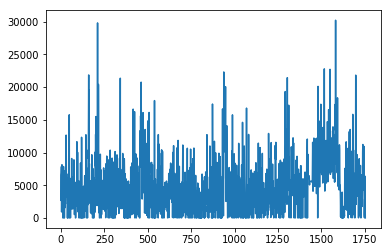

In [8]:
plt.plot(data1)

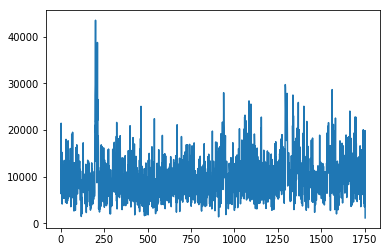

In [9]:
plt.plot(data2)

## Normality Testing

We cam use graphical and statistical methods that quantify how Gaussian a sample of data is. 

If the data fails those tests, we know to use nonparametric methods for User 1 and User 2

### Graphical Methods

#### Histogram Plot
If our samples of data has a Gaussian distribution, the histogram plot will show a bell shape.

*User 1*

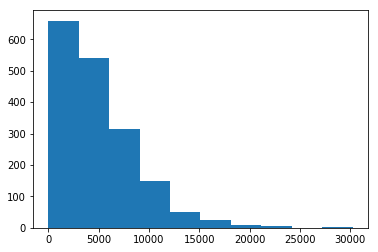

In [10]:
plt.hist(data1)
plt.show()

*User 2*

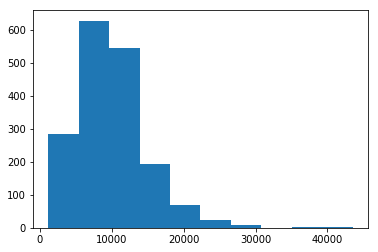

In [11]:
plt.hist(data2)
plt.show()

**Conclusion**

From above, User 1 and User 2 don't seem to have a bell shape. Thid could be due to the outliers in the data, with them having a tendency to be more than 30,000.

#### Quantile-Quantile Plots

A QQ plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups, called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

*User 1*

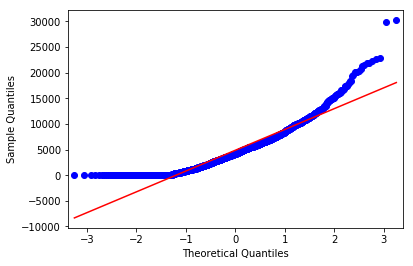

In [12]:
qqplot(data1, line = 's')
plt.show()

*User 2*

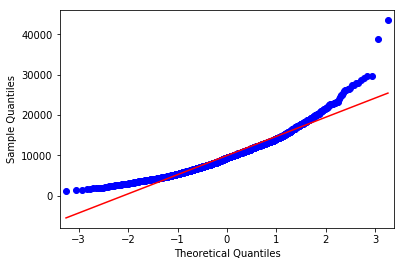

In [13]:
qqplot(data2, line = 's')
plt.show()

**Conclusion:**

There are quite a few large deviations in both User 1 and User 2 at the top and bottom of the plot. From this, we can say for the most part that our distribution is not normal.

### Statistical Methods
To provide an understanding of the terms that would be used:
- Statistic: A quantity calculated by the test that can be interpreted in the context of the test via comparing it to critical values from the distribution of the test statistic.
- p-value: Used to interpret the test, in this case whether the sample was drawn from a Gaussian distribution.

The p-value can be used to quickly and accurately interpret the shown statistics:
- **p <= alpha**: reject H0, not normal.
- **p > alpha**: fail to reject H0, normal.

A result above 5% does not mean that the null hypothesis is true. It means that it is very likely true given available evidence. 

#### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution

*User 1*

In [14]:
# Normality Test
stat, p = shapiro(data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.904, p=0.000
Sample does not look Gaussian (reject H0)


*User 2*

In [15]:
# Normality Test
stat, p = shapiro(data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.937, p=0.000
Sample does not look Gaussian (reject H0)


**Conclusion:**

User 1 and User 2 are not likely to have a Gaussian/nomral distribution.

#### D’Agostino’s K^2 Test
The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution

- Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
- Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

*User 1*

In [16]:
stat, p = normaltest(data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=453.997, p=0.000
Sample does not look Gaussian (reject H0)


*User 2*

In [17]:
stat, p = normaltest(data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=396.106, p=0.000
Sample does not look Gaussian (reject H0)


**Conclusion**

The p-value is interpreted against an alpha of 5% and we finds that the test dataset significantly deviates from the normal. 

**We can safely safe from our analysis above that User 1 and User 2 daily step count is not normal. We will now need to use non-parametric tests to ascertain further information**

## Ranking the Data
Before a nonparametric statistical method can be applied, the data must be converted into a rank format. This allows us to remove all information about the data's distribution.

The procedure is as follows:
- Sort all data in the sample in ascending order.
- Assign an integer rank from 1 to N for each unique value in the data sample.

In [24]:
ranked_data1 = rankdata(data1)
ranked_data2 = rankdata(data2)

## Compare Sample Means

### Mann-Whitney test
The Mann-Whitney test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

The default assumption or null hypothesis is that there is no difference between the distributions of the data samples. Rejection of this hypothesis suggests that there is likely some difference between the samples. More specifically, the test determines whether it is equally likely that any randomly selected observation from one sample will be greater or less than a sample in the other distribution. If violated, it suggests differing distributions.

- **Fail to Reject H0**: Sample distributions are equal.
- **Reject H0**: Sample distributions are not equal.

For the test to be effective, it requires at least 20 observations in each data sample.

Using the mannwhitneyu() SciPy function to return the test statistic and the p-value, and compare our two independent samples. We will corresponding interpret

In [25]:
#Compare Samples
stat, p = mannwhitneyu(ranked_data1, ranked_data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

#Interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=1538258.000, p=0.500
Same distribution (fail to reject H0)


**Conclusion:**

As the p-value is equal to our alpha, this suggests that the sample distributions are the same.

This finding is quite unexpected, as we expect that each individual should have a unique step pattern irrespective of the size of the "sample". As the driving question is to find different methods of doing 10hr step calculations and compare them against the paper, this finding places more importance on **how and what we take as inputs**, and allows us to more confidently compare across each method.

### Wilcoxon Signed-Rank Test
The Wilcoxon signed ranks test is a nonparametric statistical procedure for comparing two samples that are paired, or related. It is used to assess whether the two related sample's population mean rank differ. 

The parametric equivalent to the Wilcoxon signed ranks test goes by names such as the Student’s t-test, t-test for matched pairs, t-test for paired samples, or t-test for dependent samples.

The default assumption for the test, the null hypothesis, is that the two samples have the same distribution.

- **Fail to Reject H0**: Sample distributions are equal.
- **Reject H0**: Sample distributions are not equal.
For the test to be effective, it requires at least 20 observations in each data sample.

In case our data sample is paired, which can be caused by many reasons: 
- For example, the samples are related or matched in some way or represent two measurements of the same technique. In other words, although each sample is independent, they could come from the same population.


Using the wilcoxon() SciPy function, we will now use this test to take in two samples as arguments (data1, data2) and return the calculated statistic and p-value. 

In [26]:
stat, p = wilcoxon(ranked_data1,ranked_data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=759884.000, p=0.708
Same distribution (fail to reject H0)


**Conclusion**

The p-value is interpreted strongly suggesting that the samples are drawn from the same distributions. 

## Relationship Between Variables

#### What is Correlation?
Correlation refers to the association between the observed values of two variables.

The variables may have a positive association, meaning that as the values for one variable increase, so do the values of the other variable. The association may also be negative, meaning that as the values of one variable increase, the values of the others decrease. Finally, the association may be neutral, meaning that the variables are not associated.

Correlation quantifies this association, often as a measure between the values -1 to 1 for perfectly negatively correlated and perfectly positively correlated. The calculated correlation is referred to as the “correlation coefficient.” This correlation coefficient can then be interpreted to describe the measures.

- At coefficient 0, the relationship strength between the variables is none/trivial
- At coefficient +- 0.1, the relationship strength between the variables is weak/small
- At coefficient +- 0.3, the relationship strength between the variables is moderate/medium
- At coefficient +- 0.4, the relationship strength between the variables is strong/large
- At coefficient +- 1, the relationship strength between the variables is perfect

#### Rank Correlation

**Rank correlation** refers to methods that quantify the association between variables using the ordinal relationship between the values rather than the specific values. Ordinal data is data that has label values and has an order or rank relationship; for example: ‘low‘, ‘medium‘, and ‘high‘.

Rank correlation can be calculated for real-valued variables. This is done by first converting the values for each variable into rank data. This is where the values are ordered and assigned an integer rank value. Rank correlation coefficients can then be calculated in order to quantify the association between the two ranked variables.

#### Spearman's Rank Correlation
This statistical method quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0). The correlation is denoted by the lowercase greek letter rho (p).

The intuition for the Spearman’s rank correlation is that it calculates a Pearson’s correlation (e.g. a parametric measure of correlation) using the rank values instead of the real values. Where the Pearson’s correlation is the calculation of the covariance (or expected difference of observations from the mean) between the two variables normalized by the variance or spread of both variables.

In [33]:
# calculate spearman's correlation
coef, p = spearmanr(ranked_data1, ranked_data2)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.239
Samples are correlated (reject H0) p=0.000


**Conclusion**

The statistical test reports a medium positive correlation with a value of 0.24. The p-value is  zero, which means that the likelihood of observing the data given that the samples are uncorrelated is extremely unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated

**Doing another method as a check**

#### Kendall's Rank Correlation
The intuition for the test is that it calculates a normalized score for the number of matching or concordant rankings between the two samples. As such, the test is also referred to as Kendall’s concordance test. The coefficient is often referred to by the lowercase Greek letter tau (t)

The Kendall’s rank correlation coefficient can be calculated in Python using the kendalltau() SciPy function. The test takes the two data samples as arguments and returns the correlation coefficient and the p-value. As a statistical hypothesis test, the method assumes (H0) that there is no association between the two samples.


In [34]:
# calculate kendall's correlation
coef, p = kendalltau(ranked_data1,ranked_data2)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 0.163
Samples are correlated (reject H0) p=0.000


**Conclusion**

The Kendall's correlation coefficient is at 0.163, indicating a weak/small correlation. The p-value is at zero, meaning that we can confidently reject the null hypothesis that the samples are uncorrelated.

**Final Words to this Notebook**
User 1 and User 2 are statistically significant, as they have the same distribution and are positively correlated to each other (although weak/small to medium). 

These findings validate that there is a common step pattern amongst individuals, be it through a routine or otherwise, which has caused User 1 and User 2 to have the same distribution. In other words, although User 1 and User 2 are independent to each other, they both take samples from the same population. Secondly, the weak to medium correlation indicates that there is indeed a pattern, although minute at times, since their daily step counts move in the same direction for the same rank/time-periods.

Ultimately, as the driving question is to find different methods of doing 10hr step calculations and compare them against the paper, our statisitcal significance tests allows us to be more confident in the validity and results of our comparisions, given they are the same distribution and correlated, across each method. 